# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée : LDA & NMF](#section_2)

[3. Approche supervisée : Classifiers](#section_3)

[4. Approche supervisée : Doc2Vec](#section_4)

[5. Approche supervisée : Word2Vec](#section_5)

[6. Approche supervisée : BERT](#section_6)

[7. Approche non supervisée et supervisée : USE](#section_7)

[8. Choix du modèle pour le code final à déployer](#section_8)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
import copy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [3]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [4]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_1000t.csv', encoding='utf8')

In [5]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))

In [6]:
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))

In [7]:
data.head()

,Tags,Texts,Sentences
0,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,...",scope variables delegate found the following r...
1,"[mysql, database, arrays, postgresql, stored-p...","[pas, array, procedure, pas, array, procedure,...",how can pass array values stored procedure wan...
2,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, uibutton, buttonwithtype, figure, butt...",manually setting uibutton state uibutton using...
3,"[ruby-on-rails, django, zend-framework, cakeph...","[memory, footprint, web, framework, zend, djan...",how does the memory footprint some common web ...
4,"[java, performance, loops, variables, initiali...","[difference, loop, loop, performance, differen...",difference between declaring variables before ...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31917 entries, 0 to 31916
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tags       31917 non-null  object
 1   Texts      31917 non-null  object
 2   Sentences  31917 non-null  object
dtypes: object(3)
memory usage: 748.2+ KB


Le jeu de données est très important pour les temps de calculs à ma disposition.

Je décide aussi de prendre les observations pour lesquelles la similarité entre les colonnes Texts et Tags est importante.

Cela va me permettre de pouvoir regarder la pertinence des tags que mes modèles vont proposer.

In [9]:
sample_size = 10000

In [10]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1 & s2) / len(s1 | s2)

In [11]:
def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)

In [12]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences']]
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(10000, 3)


,Tags,Texts,Sentences
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da...",jquery javascript convert date string date hav...
1,"[vba, excel, function, size, byte]","[excel, function, size, byte, return, file, si...",vba excel function for returning file size byt...
2,"[sql, database, mongodb, postgresql, mongoose]","[mongodb, mongoose, postgresql, project, datab...",postgresql equivalent mongodb mongoose using p...
3,"[php, jquery, mysql, ajax, pagination]","[pagination, jquery, php, mysql, ajax, paginat...",ajax pagination with jquery php mysql looking ...
4,"[java, mysql, database, list, jdbc]","[list, java, jdbc, list, java, jdbc]",how get list databases schema names mysql usin...


In [13]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences']]
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(10000, 3)


,Tags,Texts,Sentences
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da...",jquery javascript convert date string date hav...
1,"[vba, excel, function, size, byte]","[excel, function, size, byte, return, file, si...",vba excel function for returning file size byt...
2,"[sql, database, mongodb, postgresql, mongoose]","[mongodb, mongoose, postgresql, project, datab...",postgresql equivalent mongodb mongoose using p...
3,"[php, jquery, mysql, ajax, pagination]","[pagination, jquery, php, mysql, ajax, paginat...",ajax pagination with jquery php mysql looking ...
4,"[java, mysql, database, list, jdbc]","[list, java, jdbc, list, java, jdbc]",how get list databases schema names mysql usin...


Afin de mettre en place une méthode d’évaluation propre, je décide de séparer le jeu de données en deux parties : 
 - la première me servira à l'entrainement des modèles
 - la seconde partie me permettra d'évaluer certains modèles sur des données qui leurs sont inconnues

In [14]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],
    test_size=0.5,
    random_state=42
)

In [15]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
sentences = sentences_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [16]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
sentences_list_eval = sentences_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
flat_tags_eval = [" ".join(tag) for tag in tags_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))
vocabulary_tags_eval = list(set([word for item in tags_list_eval for word in item]))

In [17]:
words = []
for text in flat_tags:
    words.extend(text.split())

counter = Counter(words)
top_500_tags = [word for word, count in counter.most_common(500)]

In [18]:
words = []
for text in flat_tags_eval:
    words.extend(text.split())

counter = Counter(words)
top_200_tags_eval = [word for word, count in counter.most_common(200)]

In [19]:
mlb = MultiLabelBinarizer(classes=top_500_tags)
tags_mlb = mlb.fit_transform(tags_list)
tags_mlb_eval = mlb.transform(tags_list_eval)

## <font color="#114b98" id="section_2">2. Approche non supervisée : LDA & NMF</font>

### Étude

In [32]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, jaccard_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [21]:
def optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test,
    and the list of texts, applies the models to the data and plots 
    the silhouette and coherence scores to help determine the optimal
    number of topics.

    """

    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    for n_topics in tqdm(n_topics_range, ascii=' >='):

        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, 
                                        max_iter=1000)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())

        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())

    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'],
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], 
                                   n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], 
                                  n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()
    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()
    plt.show()

    return scores

In [22]:
# Define the range of number of topics to test
n_topics_range = range(8, 24, 4)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [23]:
models_CountVectorizer = optimal_num_topics(flat_texts,
                                            CountVectorizer(),
                                            n_topics_range,
                                            texts_list)
models_CountVectorizer

 25%|====================>                                                              | 1/4 [12:11<36:34, 731.41s/it]


KeyboardInterrupt: 

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [ ]:
models_TfidfVectorizer = optimal_num_topics(flat_texts,
                                            TfidfVectorizer(vocabulary=vocabulary_texts),
                                            n_topics_range,
                                            texts_list)
models_TfidfVectorizer

Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont davantage "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores de silhouette.

Je choisis le nombre de topics au regard des résultats précédents.

In [24]:
n_topics = 16

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [25]:
min_df = 25

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [26]:
max_df = 0.2

Visualisation des topics avec CountVectorizer

In [52]:
vectorizer_CV = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
vcv = vectorizer_CV.fit_transform(flat_texts)
CV_feature_names = vectorizer_CV.get_feature_names()

In [53]:
n_features = 1000
n_top_words = 10

def plot_top_words(model, feature_names, n_top_words, title, color):
    fig, axes = plt.subplots(4, 4, figsize=(30, 25), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

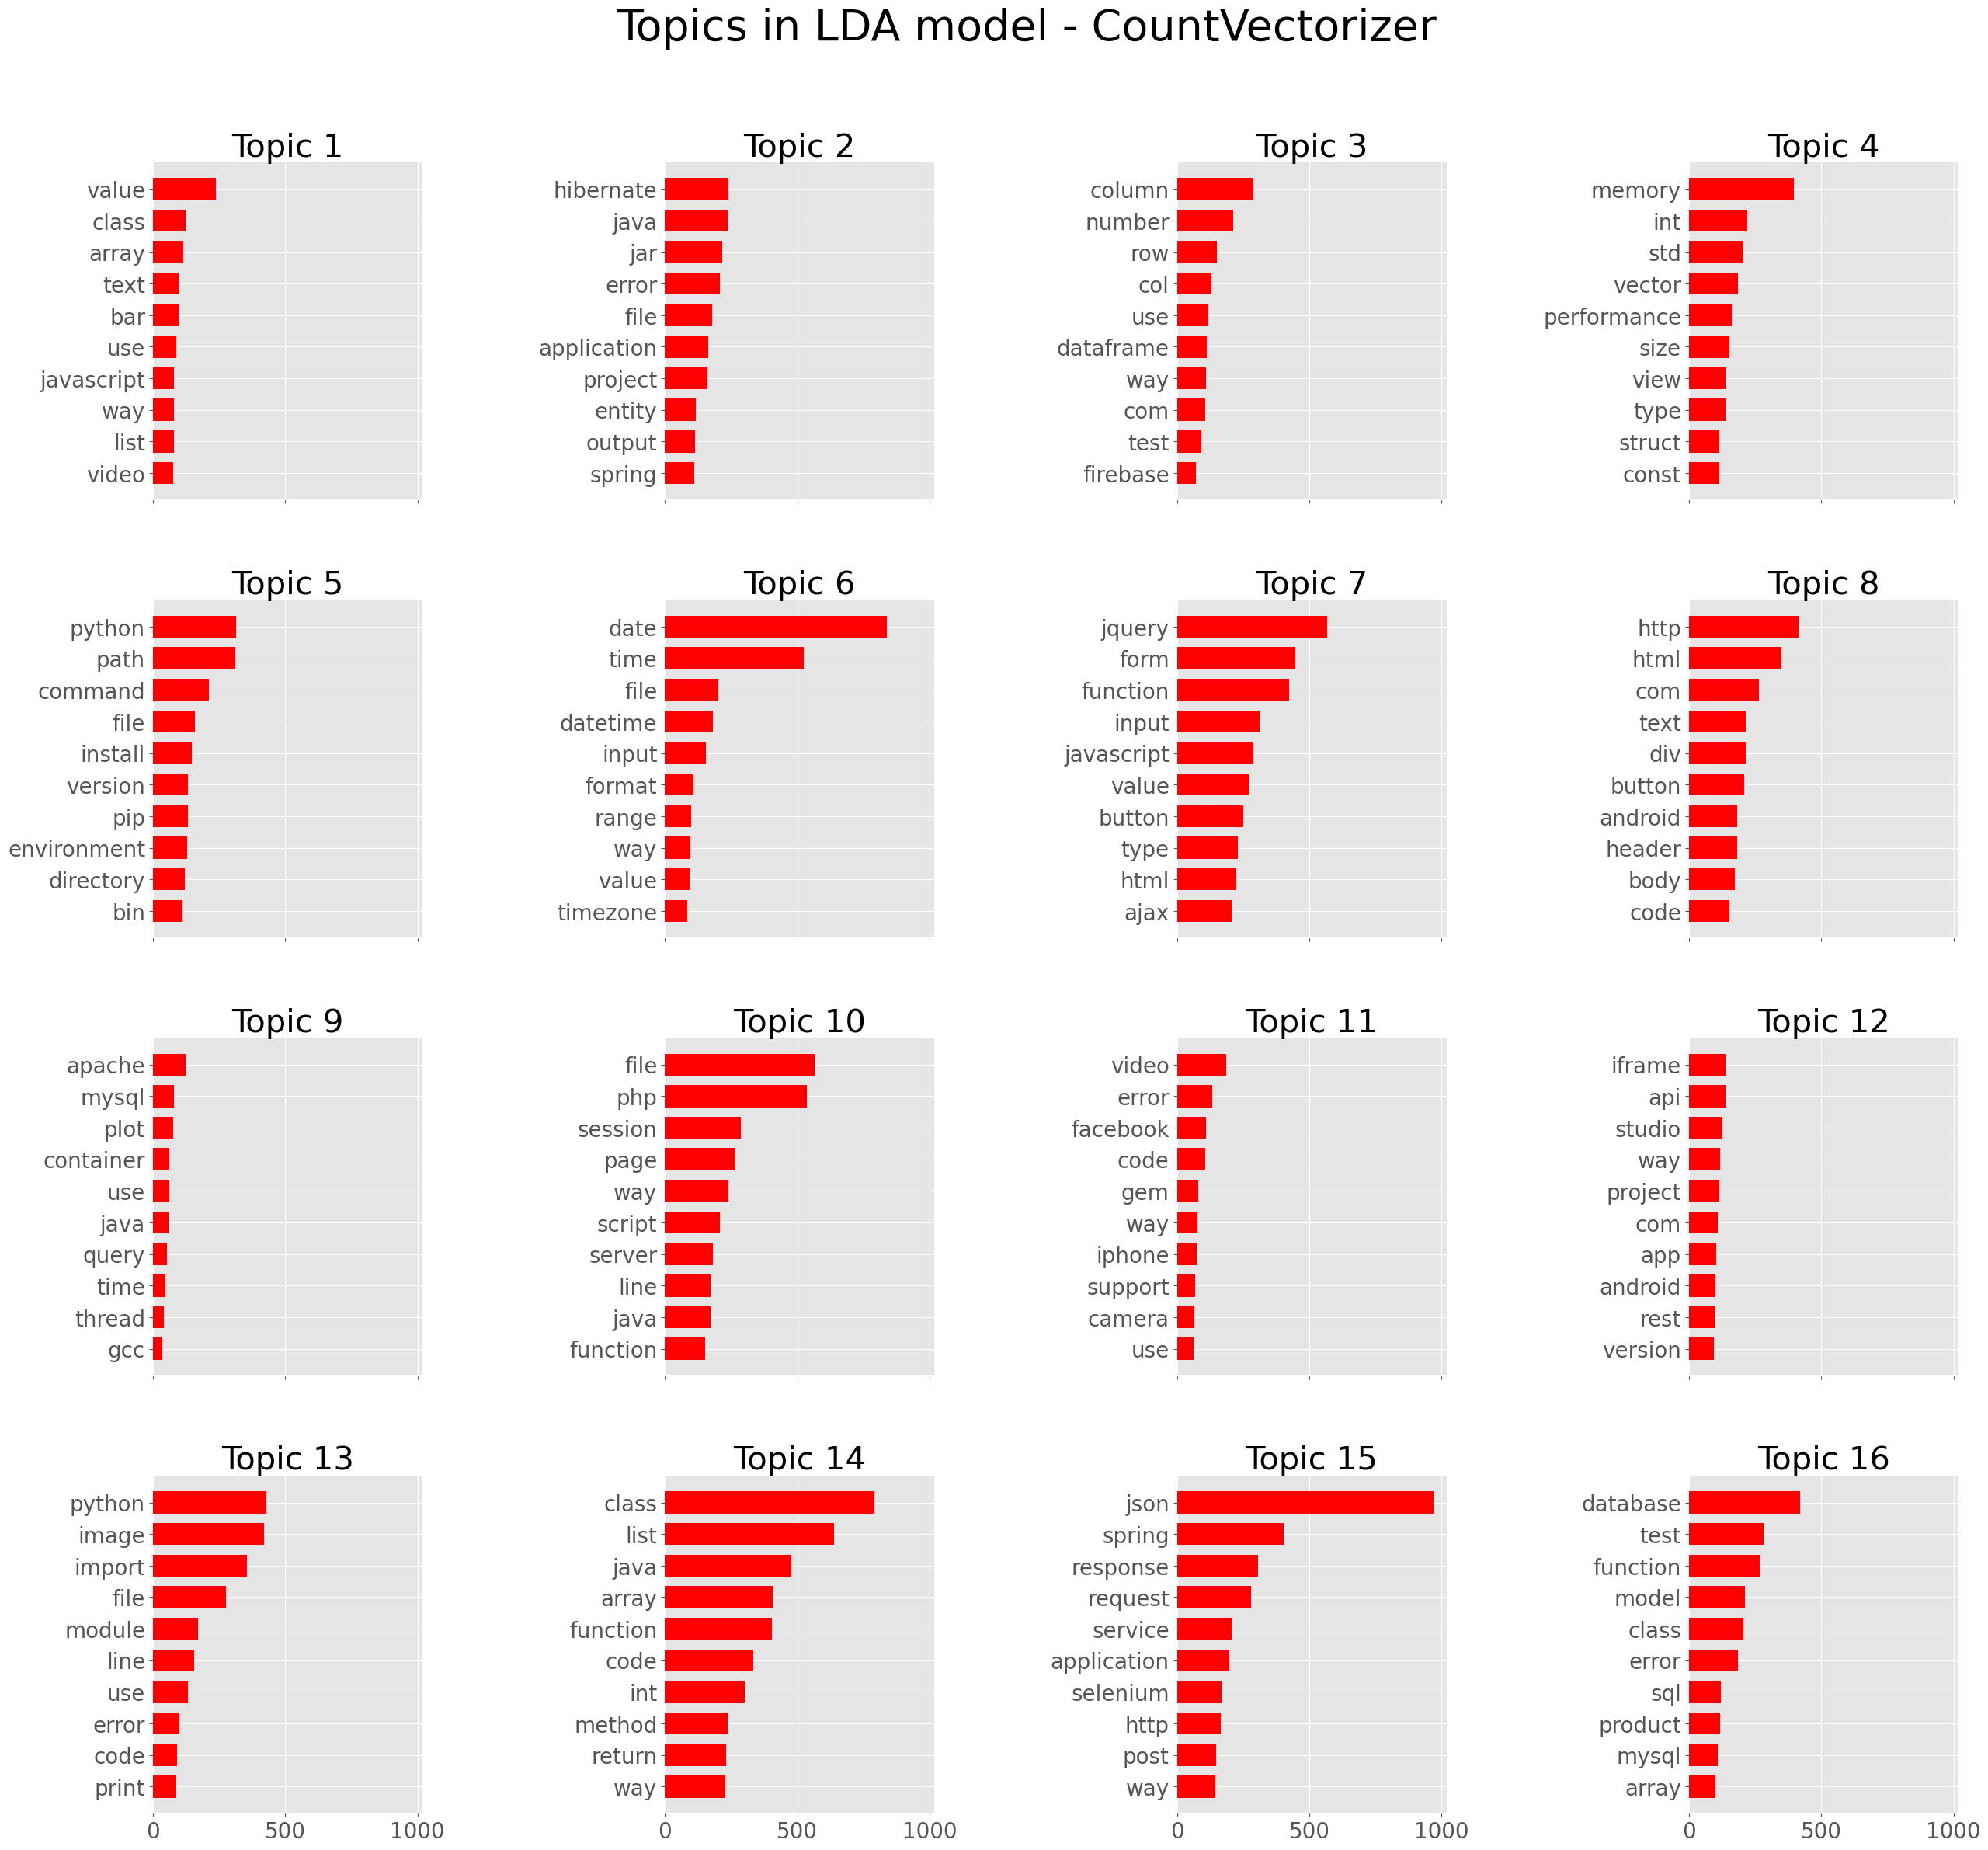

In [54]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                random_state=42).fit(vcv)

plot_top_words(lda, CV_feature_names, n_top_words, 'Topics in LDA model - CountVectorizer', 'red')

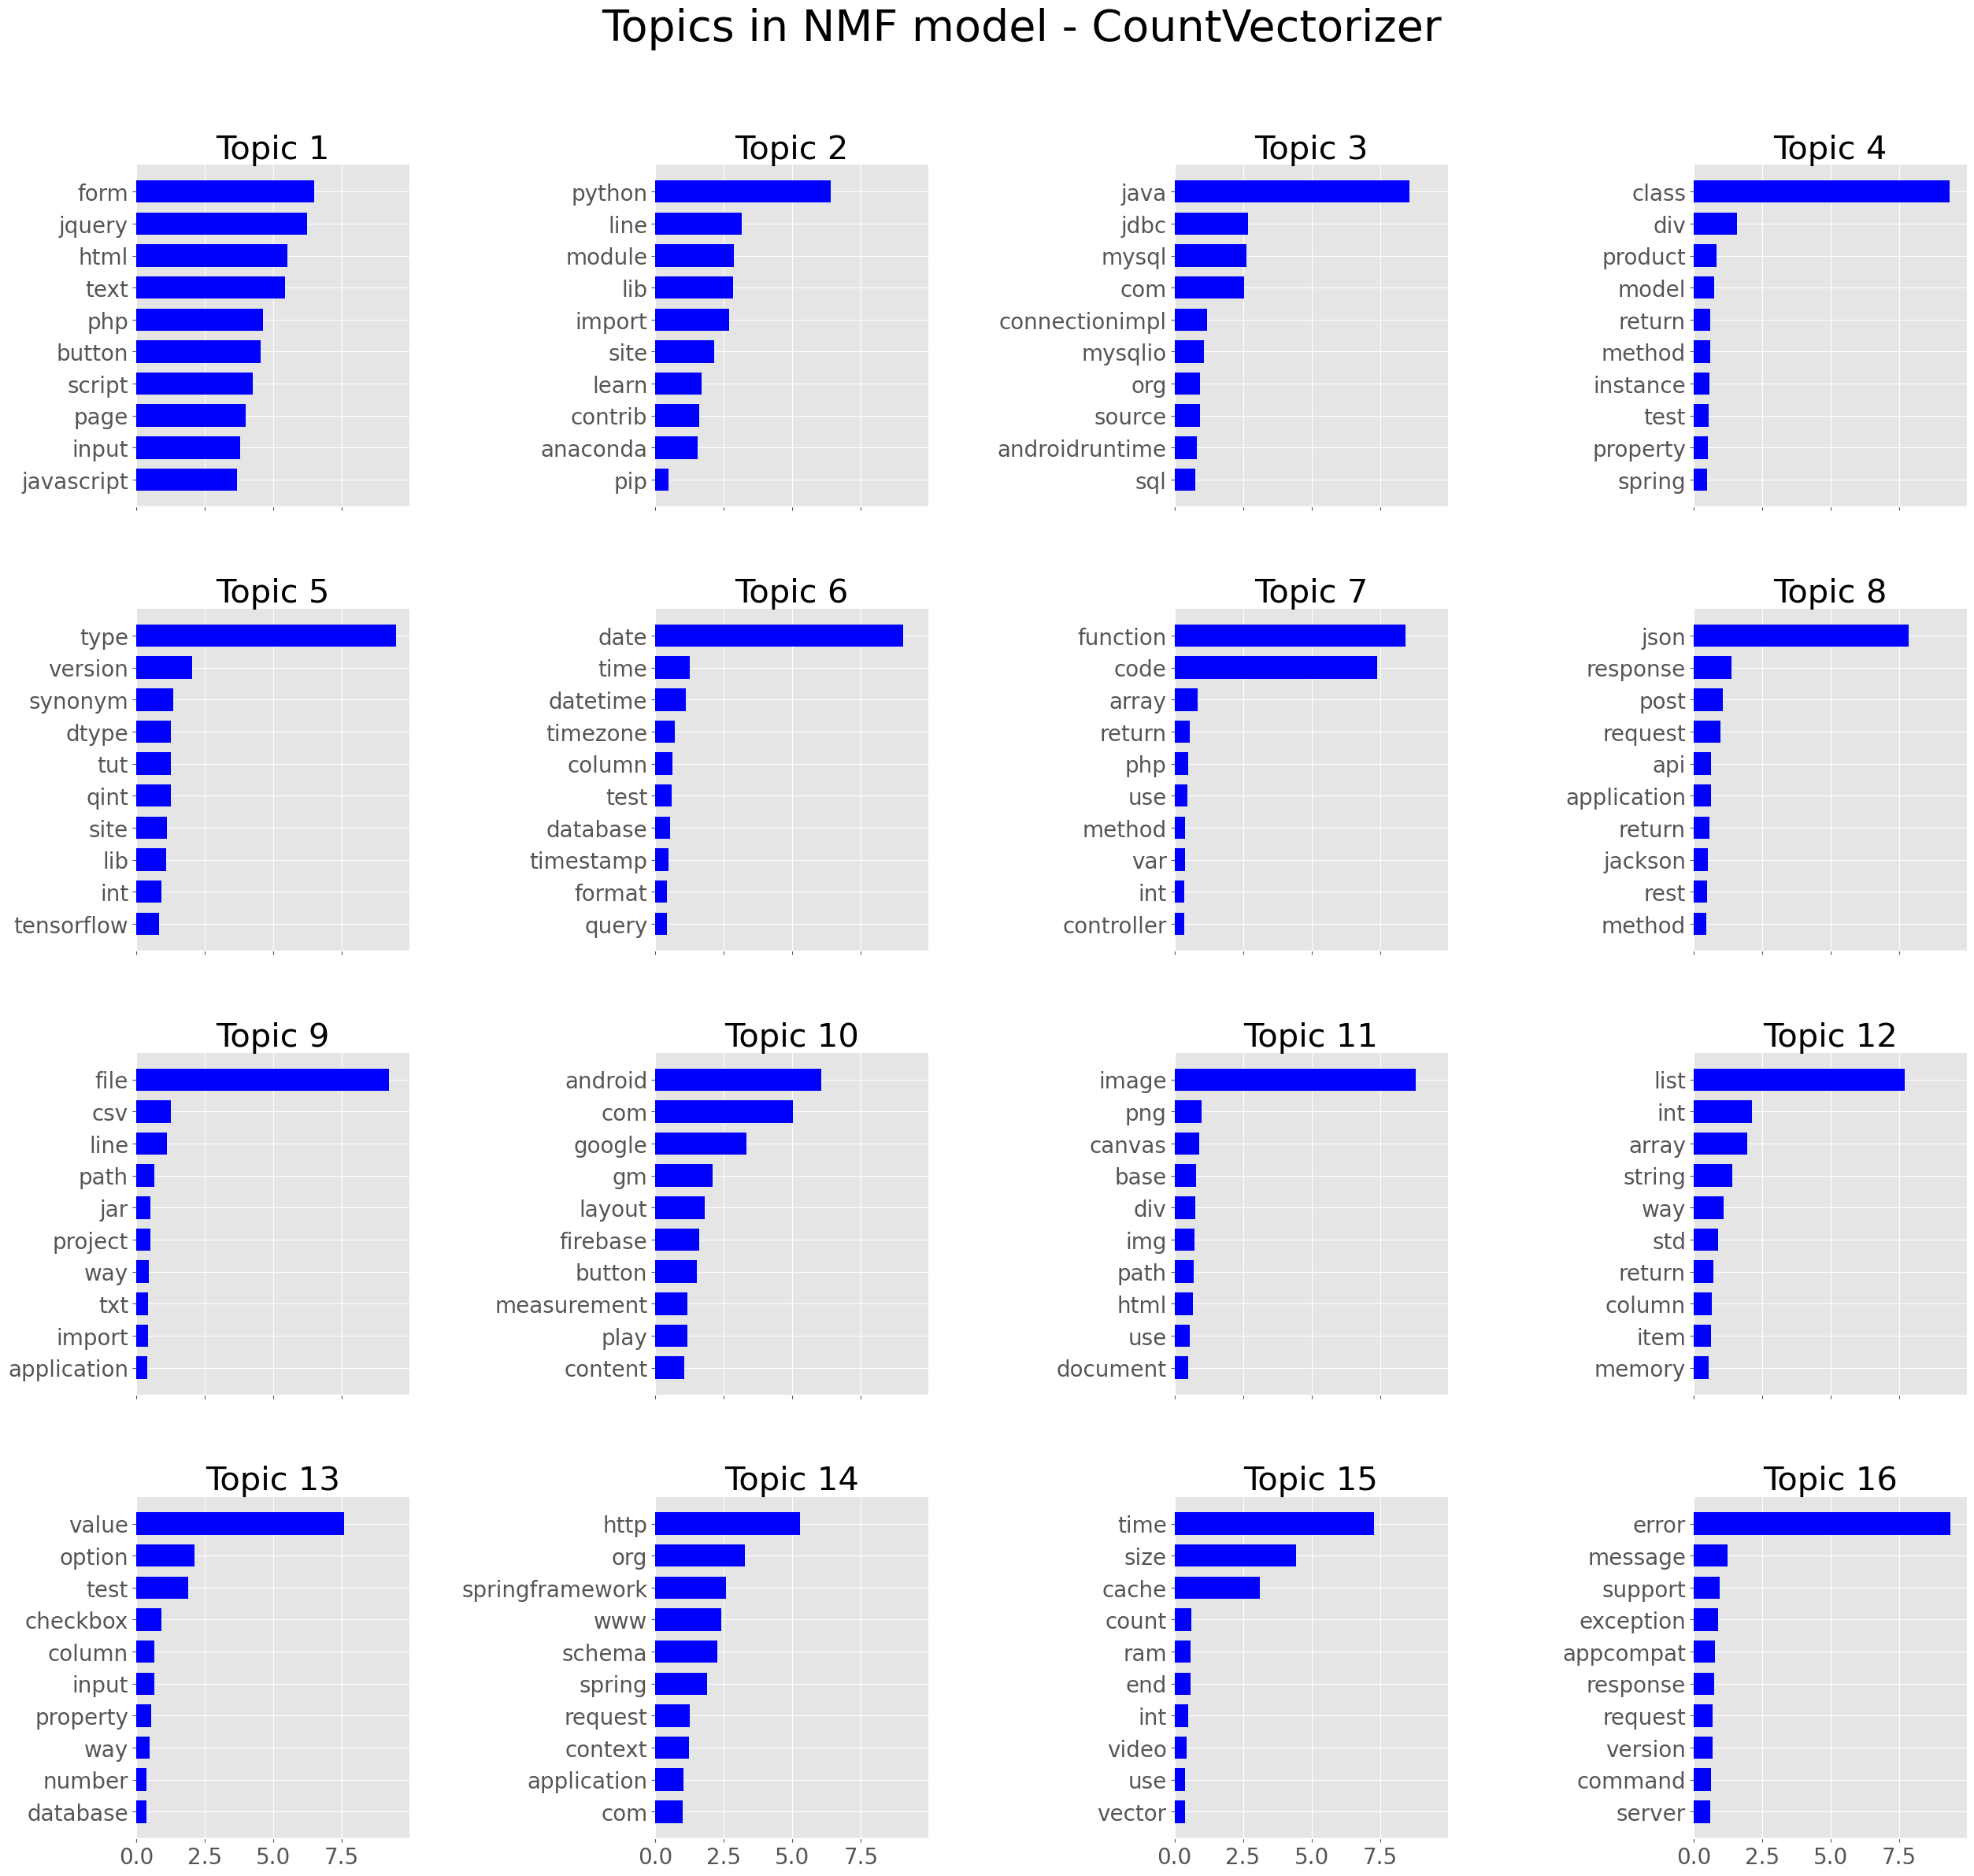

In [55]:
nmf = NMF(n_components=n_topics, random_state=42).fit(vcv)

plot_top_words(nmf, CV_feature_names, n_top_words,
               'Topics in NMF model - CountVectorizer', 'blue')

Visualisation des topics avec TFIDF

In [56]:
vectorizer_TFIDF = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
tfidf = vectorizer_TFIDF.fit_transform(flat_texts)
TFIDF_feature_names = vectorizer_TFIDF.get_feature_names()

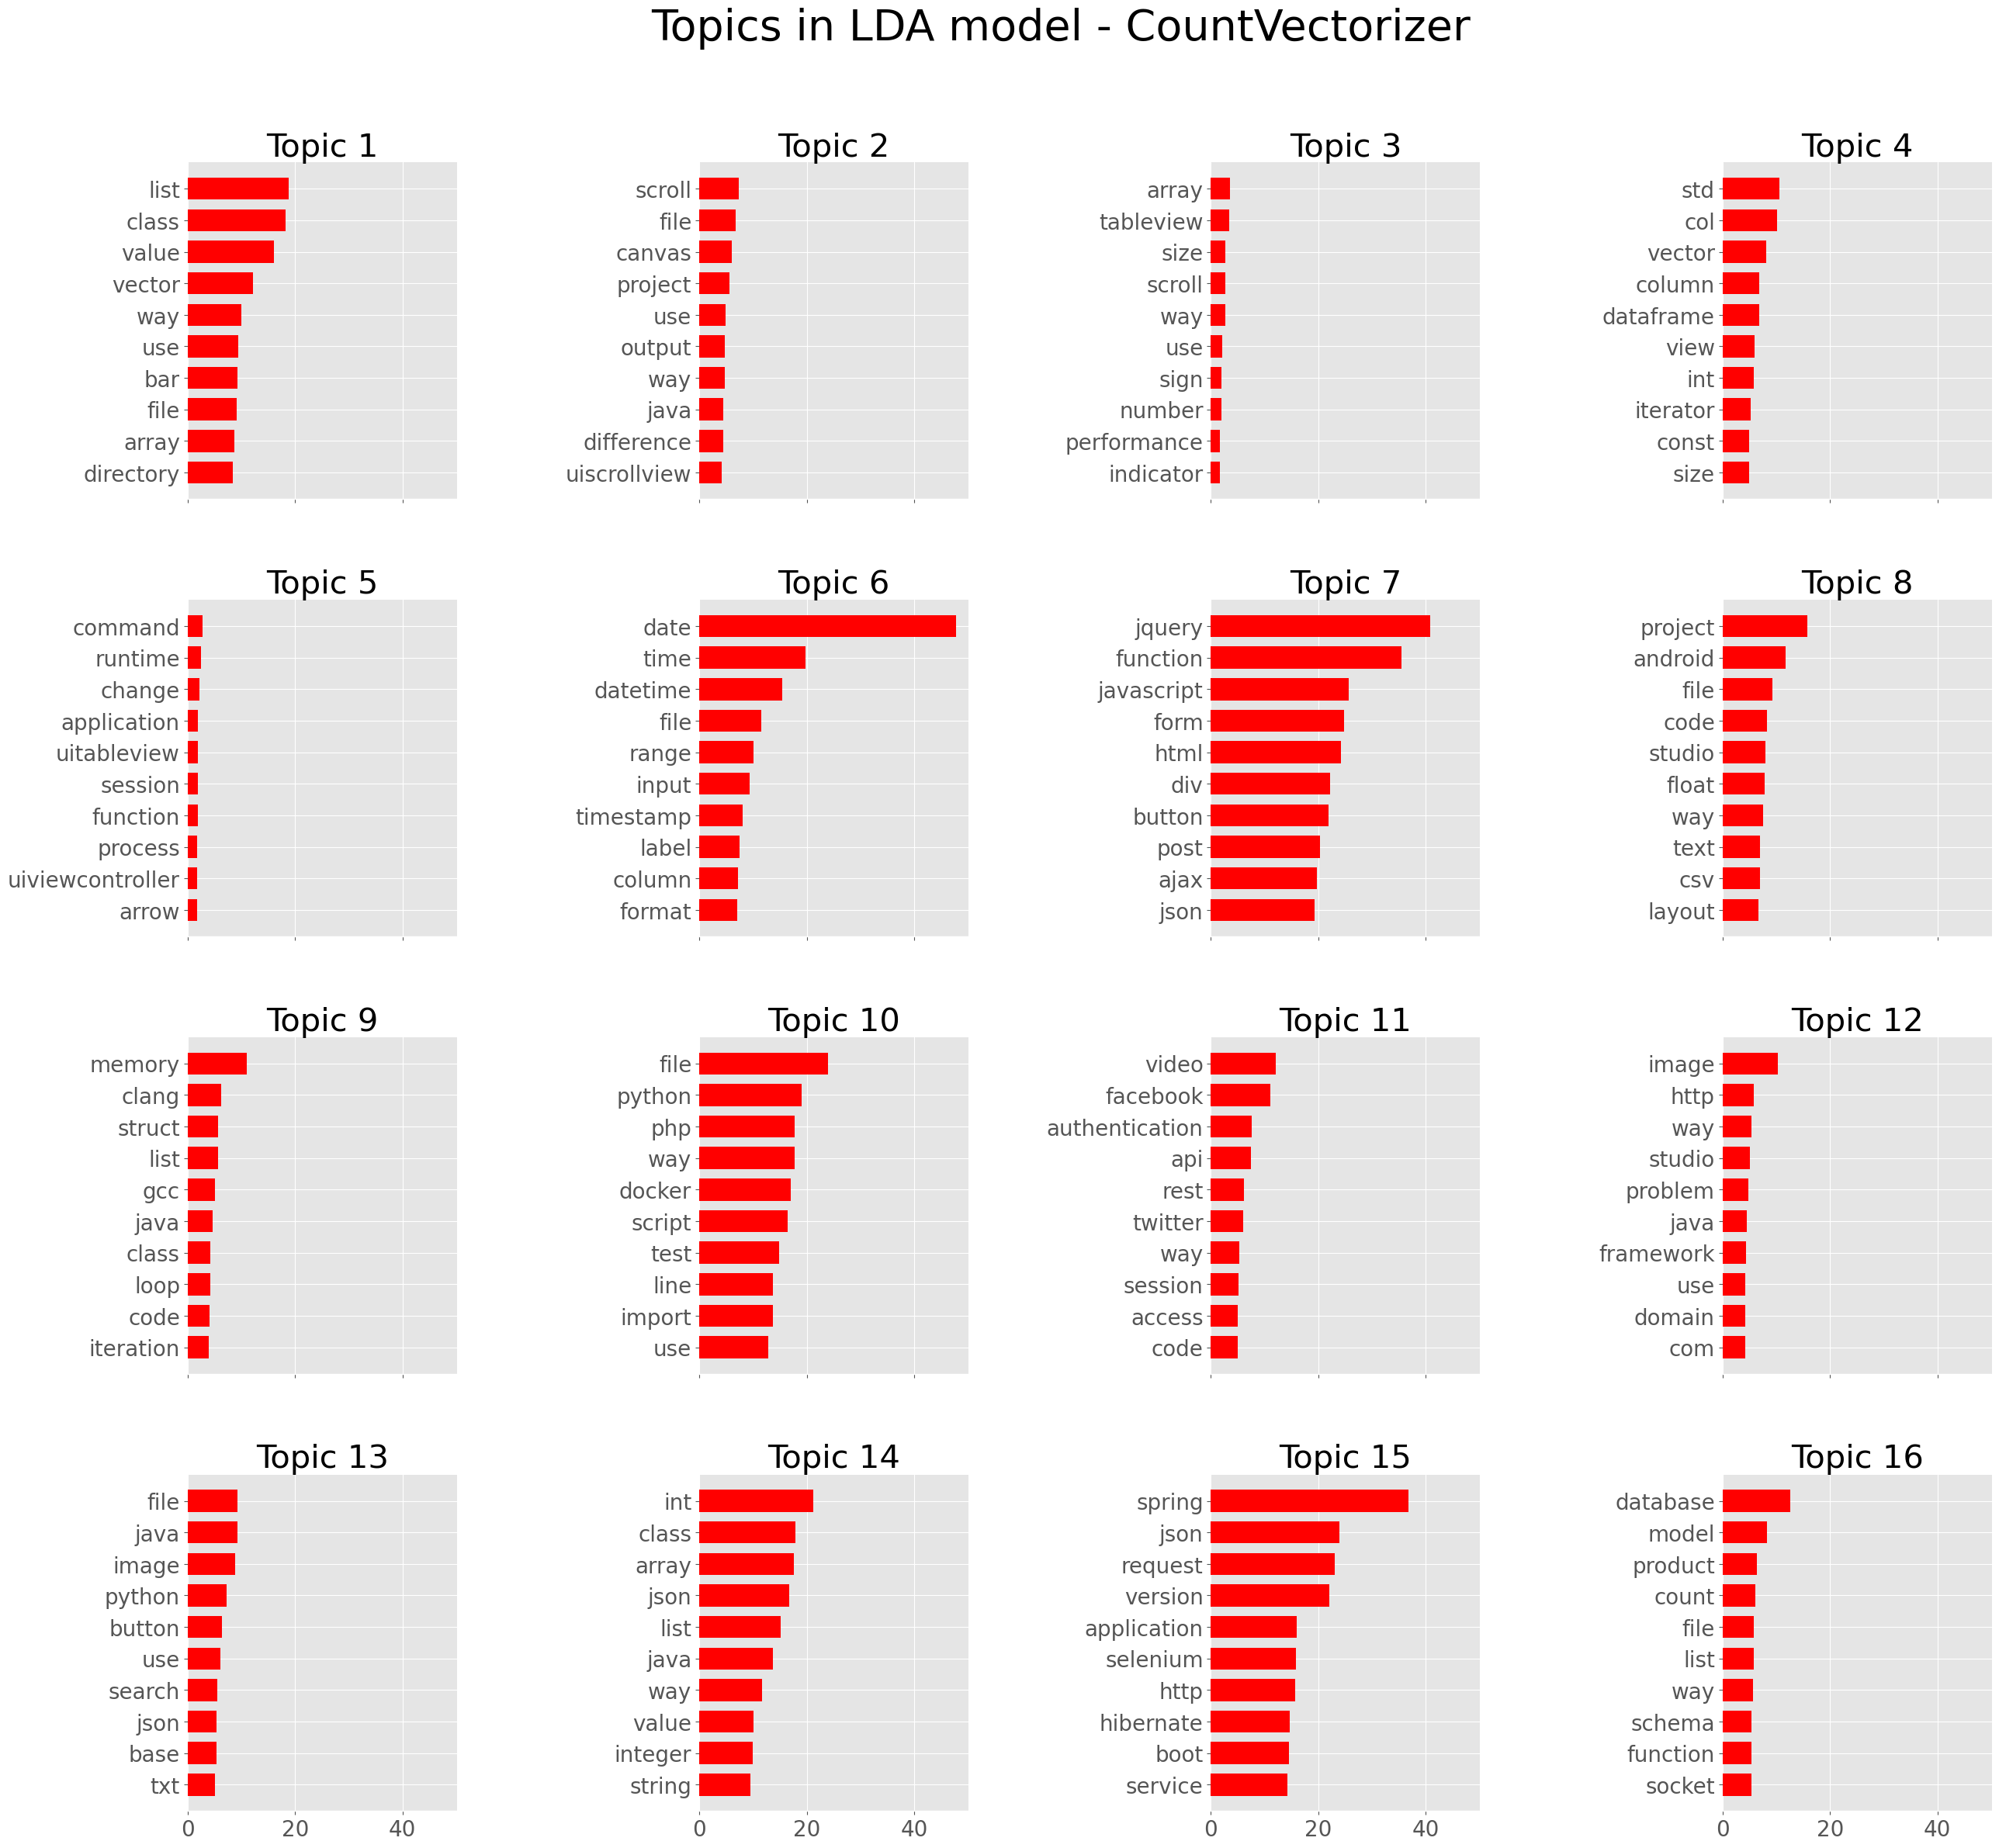

In [57]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                random_state=42).fit(tfidf)

plot_top_words(lda, TFIDF_feature_names, n_top_words, 'Topics in LDA model - CountVectorizer', 'red')

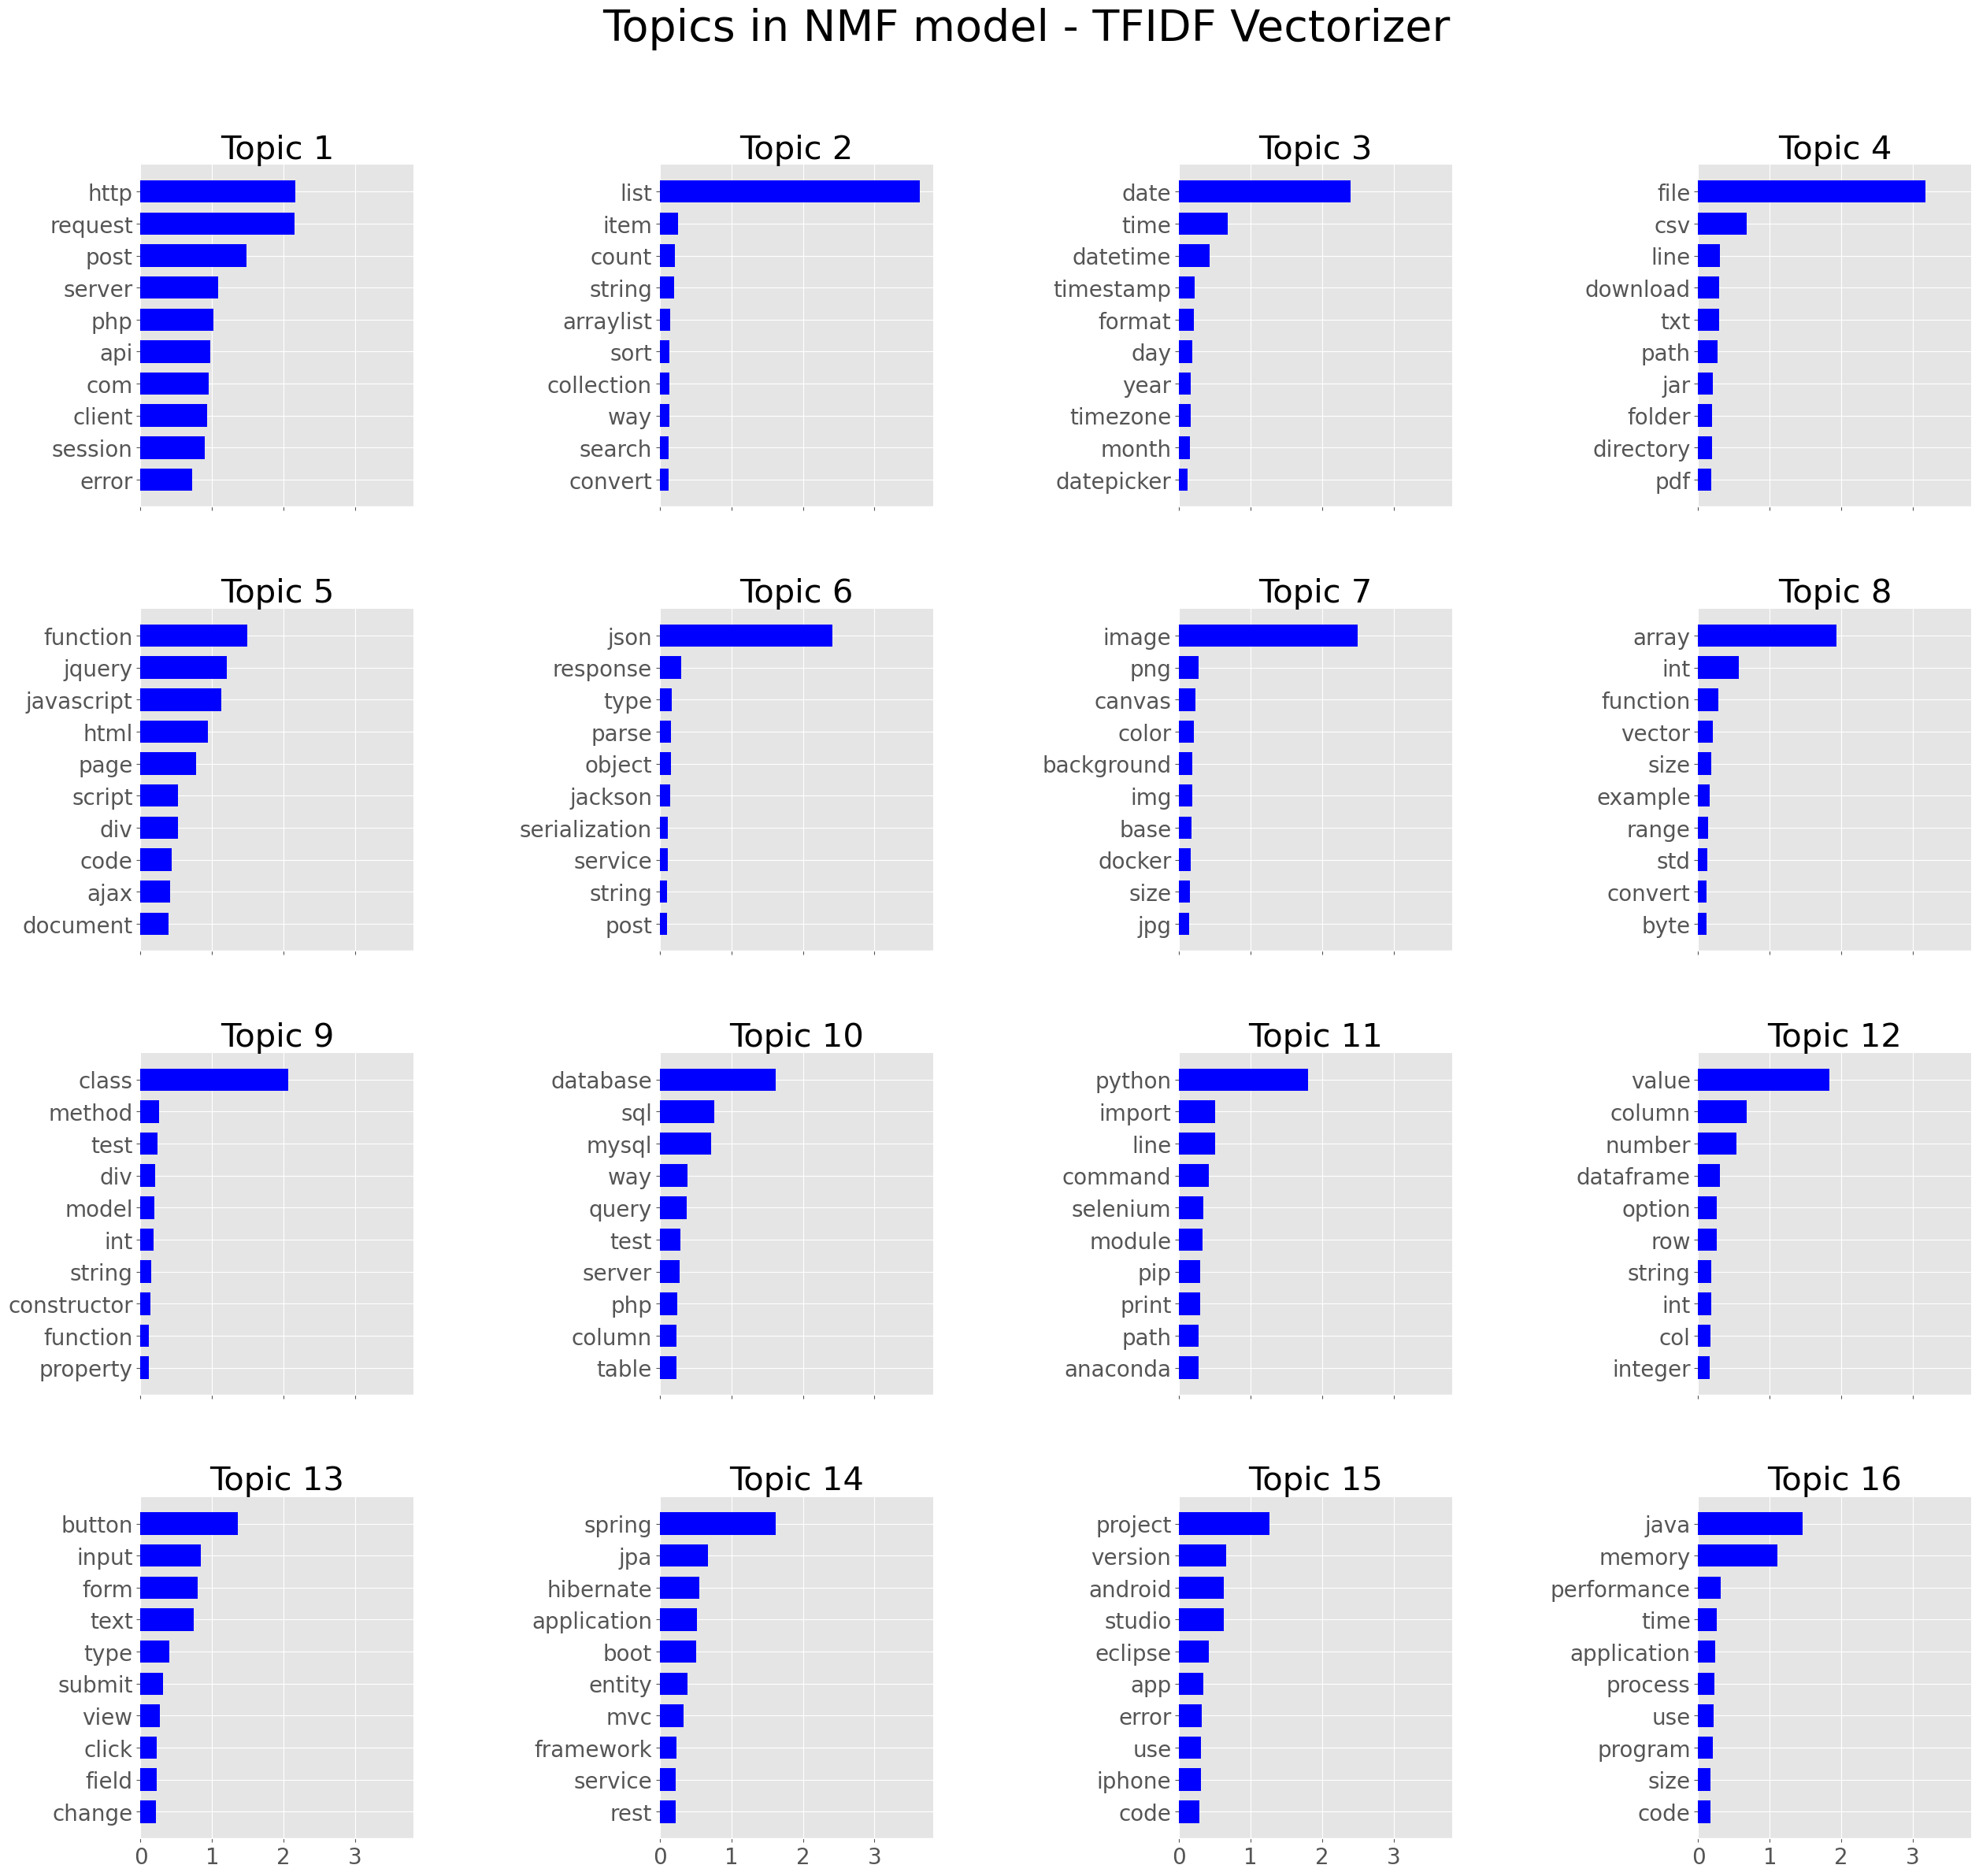

In [58]:
nmf = NMF(n_components=n_topics, random_state=42).fit(tfidf)

plot_top_words(nmf, TFIDF_feature_names, n_top_words,
               'Topics in NMF model - TFIDF Vectorizer', 'blue')

In [59]:
def plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.ravel()

    # LDA with vcv
    X_embedded = TSNE(n_components=2).fit_transform(lda_vcv)
    axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_vcv.argmax(axis=1))
    axs[0].set_title("LDA with vcv")
    
    # LDA with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(lda_tfidf)
    axs[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_tfidf.argmax(axis=1))
    axs[1].set_title("LDA with tfidf")
    
    # NMF with vcv
    X_embedded = TSNE(n_components=2).fit_transform(nmf_vcv)
    axs[2].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_vcv.argmax(axis=1))
    axs[2].set_title("NMF with vcv")
    
    # NMF with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(nmf_tfidf)
    axs[3].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_tfidf.argmax(axis=1))
    axs[3].set_title("NMF with tfidf")
    
    plt.show()

In [60]:
lda_vcv = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit_transform(vcv)
lda_tfidf = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit_transform(tfidf)
nmf_vcv = NMF(n_components=n_topics, random_state=42).fit_transform(vcv)
nmf_tfidf = NMF(n_components=n_topics, random_state=42).fit_transform(tfidf)

In [ ]:
plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf)

In [ ]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    pred_gensim = list()
    pred_sklearn = list()
    pred_tfidf = list()
    pred_countvectorizer = list()

    # Predict tags using LdaModel (gensim) without bow or TF-IDF
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in tqdm(texts_list, ascii=' >= '):
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        pred_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in tqdm(texts_list, ascii=' >='):
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        pred_sklearn.append(topic_words)

    # Predict tags using LdaModel with TF-IDF
    vectorizer = vectorizer_TFIDF
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tfidf.append(topic_words)

    # Predict tags using LdaModel with CountVectorizer
    vectorizer = vectorizer_CV
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_countvectorizer.append(topic_words)           

    return pred_gensim, pred_sklearn, pred_tfidf, pred_countvectorizer

In [ ]:
pred_gensim, pred_sklearn, pred_tfidf, pred_countvectorizer = get_tags_from_text(texts_list,
                                                                                 flat_texts,
                                                                                 n_topics,
                                                                                 vocabulary_texts,
                                                                                 min_df,
                                                                                 max_df)

In [ ]:
tags_list[0:5]

In [ ]:
pred_gensim[0:5]

In [ ]:
pred_sklearn[0:5]

In [ ]:
pred_tfidf[0:5]

In [ ]:
pred_countvectorizer[0:5]

Il semblerait que les modèles avec CountVectorizer et TfidfVectorizer prédisent des tags assez similaires à ceux donnés par les utilisateurs.

In [ ]:
pred_tags_list = [pred_gensim, pred_sklearn, pred_tfidf, pred_countvectorizer]
pred_names = ["gensim", "sklearn", "tfidf", "count"]

In [ ]:
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [ ]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    scoring_methods = ["F1 Score", "Jaccard Score"]
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))

    metrics = {"Jaccard": jaccard_scores, "F1": f1_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set_ylabel('Score')
        axes[i].set_title(scoring_methods[i])
    plt.show()
    return metrics_df

 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [ ]:
evaluate_predictions(tags_mlb, pred_tags_bin_list, pred_names)

Nous observons de meilleurs scores avec un vectorizer.

### Résultats de l'étude

In [ ]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    if not s1 and not s2:
        return 0
    return len(s1 & s2) / len(s1 | s2)


def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def jaccard_index_mod(list1, list2):
    """ 
    Fonction jaccard_index modifiée
    La division ne se fait pas sur l'union des deux set
    mais par le nombre de tags prédits (list2)
    afin de ne pas pénaliser les scores des observations
    avec moins de 5 tags
    """
    s1 = set(list1)
    s2 = set(list2)
    if not s1 or not s2:
        return 0
    return len(s1 & s2) / min(len(s1),len(s2))


def calculate_scores_mod(tags_list, pred_tags):
    scores = [jaccard_index_mod(t, p) for t, p in zip(tags_list, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def plot_similar_tags(tags_list, pred_tags, method):
    mean_score = calculate_scores(tags_list, pred_tags)
    mean_score_mod = calculate_scores_mod(tags_list, pred_tags)
    similar_counts = []
    for pred_tags, tags_list in zip(pred_tags, tags_list):
        similar_words = set(pred_tags) & set(tags_list)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14,
                 fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0, 6, 1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n"
                     "nombre de tags similaires", fontsize=12)
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(),
               autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8},
                 title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n"
                     "un nombre de tags similaires", fontsize=12)

    textstr = f'Jaccard_index = {mean_score:.2f}\nJaccard_index_mod = {mean_score_mod:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    plt.show()

In [ ]:
plot_similar_tags(tags_list, pred_gensim, 'LDA Gensim')

In [ ]:
plot_similar_tags(tags_list, pred_sklearn, 'LDA Sklearn')

In [ ]:
plot_similar_tags(tags_list, pred_tfidf, 'LDA + TFIDF')

In [ ]:
plot_similar_tags(tags_list, pred_countvectorizer, 'LDA + CountVectorizer')

Les vectorizers apportent une réelle plus value avec davantage de tags prédis similaires aux tags originaux.

### LDA + TF-IDF +  PCA

In [ ]:
# Predict tags using LdaModel with TF-IDF
vectorizer = vectorizer_TFIDF
bow = vectorizer.fit_transform(flat_texts)

# Apply PCA to the TF-IDF matrix
pca = PCA()
pca_bow = pca.fit_transform(bow.toarray())

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the explained variance
axs[0].plot(np.cumsum(explained_variance))
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Explained Variance (%)")
axs[0].axhline(y=0.90, linewidth=2, color='black')
axs[0].text(2, 0.91, 'Seuil des 90% de variance', fontsize=14)

# Scatter Plot of PCA Results
axs[1].scatter(pca_bow[:, 0], pca_bow[:, 1])
axs[1].set_xlabel("First Principal Component")
axs[1].set_ylabel("Second Principal Component")
axs[1].set_title("Scatter Plot of PCA Results")

plt.tight_layout()
plt.show()

In [ ]:
def ensure_positive_pca(X):
    pca = PCA(n_components=0.90)
    X_transformed = pca.fit_transform(X)
    if (X_transformed < 0).sum() > 0:
        X_transformed -= X_transformed.min()
    return X_transformed

In [ ]:
pca_bow = ensure_positive_pca(bow.toarray())

In [ ]:
# Predict tags using LdaModel with CountVectorizer
pred_tfidf_pca = list()
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(pca_bow)
for i in tqdm(range(len(texts_list)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    top_words_indices = pca_bow[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_pca.append(topic_words)  

In [ ]:
pred_tfidf_pca[0:5]

In [ ]:
tags_list[0:5]

In [ ]:
plot_similar_tags(tags_list, pred_tfidf_pca, 'LDA + TFIDF + PCA')

PCA est une méthode non supervisée qui cherche à identifier les composantes principales ou les caractéristiques qui expliquent la variance la plus importante dans les données. Bien qu'il puisse être utilisé pour la réduction de la dimensionnalité et la visualisation, il ne garantit pas que les caractéristiques transformées soient liées à la cible. Dans votre cas, les caractéristiques transformées PCA semblent avoir perdu le sens sémantique des mots d'origine. Cela peut être dû à diverses raisons, telles que le choix de n_components ou la petite taille de l'ensemble de données.

In [ ]:
# Predict tags using LdaModel with TF-IDF
vectorizer = vectorizer_TFIDF
bow = vectorizer.fit_transform(flat_texts)

# Predict tags using LdaModel with CountVectorizer
pred_tfidf_pca = list()
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(bow.toarray())

# # Apply PCA to the topic distributions
# pca = PCA()
# pca_topics = pca.fit_transform(topics)

def ensure_positive_pca(X):
    pca = PCA(n_components=0.90)
    X_transformed = pca.fit_transform(X)
    if (X_transformed < 0).sum() > 0:
        X_transformed -= X_transformed.min()
    return X_transformed

pca_topics = ensure_positive_pca(topics)

for i in tqdm(range(len(texts_list)), ascii=' >='):
    topic_id = pca_topics.argmax(axis=1)[i]
    top_words_indices = topics[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_pca.append(topic_words)  


In [ ]:
pred_tfidf_pca[0:5]

### LDA + CountVectorizer +  PCA 

In [ ]:
# Predict tags using LdaModel with CountVectorizer
vectorizer = vectorizer_CV
bow = vectorizer_CV.fit_transform(flat_texts)

# Apply PCA to the count matrix
pca = PCA()
pca_bow = pca.fit_transform(bow.toarray())

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the explained variance
axs[0].plot(np.cumsum(explained_variance))
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Explained Variance (%)")
axs[0].axhline(y=0.90, linewidth=2, color='black')
axs[0].text(2, 0.91, 'Seuil des 90% de variance', fontsize=14)

# Scatter Plot of PCA Results
axs[1].scatter(pca_bow[:, 0], pca_bow[:, 1])
axs[1].set_xlabel("First Principal Component")
axs[1].set_ylabel("Second Principal Component")
axs[1].set_title("Scatter Plot of PCA Results")

plt.tight_layout()
plt.show()

In [ ]:
pca_bow = ensure_positive_pca(bow.toarray())

In [ ]:
# Predict tags using LdaModel with CountVectorizer
pred_count_pca = list()
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(pca_bow)
for i in tqdm(range(len(texts_list)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    top_words_indices = pca_bow[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_count_pca.append(topic_words)           

In [ ]:
plot_similar_tags(tags_list, pred_count_pca, 'LDA + CountVectorizer + PCA')

## <font color="#114b98" id="section_3">3. Approche supervisée : Classifiers</font>

### Étude

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [ ]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
#                RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

In [ ]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier',
                                       'F1 Score',
                                       'Jaccard Score',
                                       'Time (s)'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)

    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in tqdm(classifiers, ascii=' >='):
        start_time = time.time()
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()

        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)

        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                        'F1 Score': f1,
                                        'Jaccard Score': jaccard,
                                        'Time (s)': time_taken},
                                        ignore_index=True)

    return results_df

In [ ]:
results_CountVectorizer = calculate_supervised_scores(flat_texts,
                                                      tags_mlb,
                                                      vectorizer_CV,
                                                      classifiers)

In [ ]:
results_CountVectorizer

In [ ]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)

    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['F1 Score', 'Jaccard Score', 'Time (s)']

    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i], 
                    palette=my_palette, 
                    label=scoring_method)

    # Add classifier names to x-axis
    for i in range(3):
        axs[i].set_title(scoring_methods[i])
        axs[i].set_xticks(x)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Score')
        axs[i].set_xticklabels(results_df['Classifier'], rotation=90)

    plt.show()

In [ ]:
plot_results(results_CountVectorizer)

In [ ]:
results_TfidfVectorizer = calculate_supervised_scores(flat_texts,
                                                      tags_mlb,
                                                      vectorizer_TFIDF,
                                                      classifiers)

In [ ]:
results_TfidfVectorizer

In [ ]:
plot_results(results_TfidfVectorizer)

Le SGDClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

Le modèle avec RandomForestClassifier nécessite un temps d'entraînement très long.

Le classificateur LogisticRegression semble assez performant avec CountVectorizer.

### LogisticRegression + GridSearchCV

In [ ]:
results_LR = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_LR = results_LR.append(results_CountVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR = results_LR.append(results_TfidfVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_LR

In [ ]:
plot_results(results_LR)

CountVectorizer permet d'avoir des performances largement supérieures à TF-IDF.

In [ ]:
classifier_LR = LogisticRegression(random_state=42, max_iter=300, tol=1e-5)

In [ ]:
parameters_LR = {'estimator__C': [0.01, 0.1, 0.01],
                 'estimator__penalty': ['l1', 'l2'],
                 'estimator__solver': ['lbfgs', 'liblinear']}

In [ ]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifier, parameters):
    results_df = pd.DataFrame(columns=['Classifier', 'F1 Score', 'Jaccard Score', 'Time (s)'])
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    ovrc = OneVsRestClassifier(classifier)
    clf = GridSearchCV(ovrc, parameters, cv=5, verbose=1)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = time.time()
    
    best_params = clf.best_params_ if hasattr(clf, 'best_params_') else None
    
    f1 = round(f1_score(y_test, y_pred, average='samples'), 4)
    jaccard = round(jaccard_score(y_test, y_pred, average='samples'), 4)
    time_taken = round(end_time - start_time, 4)
    
    results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                    'F1 Score': f1,
                                    'Jaccard Score': jaccard,
                                    'Time (s)': time_taken},
                                    ignore_index=True)
    return results_df, best_params

In [ ]:
results_LR, best_params_LR = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer_CV,
                                                         classifier_LR,
                                                         parameters_LR)

In [ ]:
results_LR

Ce modèle est légèrement amélioré mais il reste toujours très inférieur au modèle non hyperparamétré avec SGDClassifier.

In [ ]:
params_LR = {key.replace('estimator__', ''): value for key, value in best_params_LR.items()}

In [ ]:
classifier = LogisticRegression(random_state=42, max_iter=300, tol=1e-5, **params_LR)

In [ ]:
ovrc_LR = OneVsRestClassifier(classifier)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_CV.fit_transform(X_train)
ovrc_LR.fit(X_train, y_train)

In [ ]:
X_test_ = vectorizer_CV.fit_transform(X_test)
y_pred_LR = ovrc_LR.predict(X_test_)

In [ ]:
tags_LR = mlb.inverse_transform(y_pred_LR)
tags_LR[0:5]

In [ ]:
count = 0
for i in tags_LR:
    if len(i) >= 3:
        count += 1

print("The number of tuples with 3 or more words in the list is:", count)

In [ ]:
true_tags_1 = mlb.inverse_transform(y_test)
true_tags_1[0:5]

In [ ]:
plot_similar_tags(true_tags_1, tags_LR, 'CountVectorizer + LogisticRegression')

### SGDClassifier + GridSearchCV

In [ ]:
results_SGD = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_SGD = results_SGD.append(results_CountVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD = results_SGD.append(results_TfidfVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_SGD

In [ ]:
plot_results(results_SGD)

CountVectorizer permet d'avoir des performances légèrement supérieures à TF-IDF.

In [ ]:
classifier_SGD = SGDClassifier(random_state=42)

In [ ]:
parameters_SGD = {'estimator__alpha': [0.001, 0.01, 0.1],
#                   'estimator__loss': ['hinge', 'log', 'modified_huber'],
                  'estimator__penalty': ['l1', 'l2']}

In [ ]:
results_SGD, best_params_SGD = calculate_supervised_scores(flat_texts,
                                                           tags_mlb,
                                                           vectorizer_CV,
                                                           classifier_SGD,
                                                           parameters_SGD)

In [ ]:
results_SGD

In [ ]:
best_params_SGD

In [ ]:
results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier']

In [ ]:
results_CV = pd.concat([results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier'],
                        results_SGD])
results_CV.iloc[1,0] = 'SGDClassifier_CV'
results_CV

In [ ]:
# Call the plot_results function
plot_results(results_CV)

Le modèle a bien pu être amélioré par Cross-Validation.

### Résultats de l'étude

In [ ]:
params_SGDC = {key.replace('estimator__', ''): value for key, value in best_params_SGD.items()}

In [ ]:
classifier = SGDClassifier(random_state=42, **params_SGDC)

In [ ]:
ovrc_SGDC = OneVsRestClassifier(classifier)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_CV.fit_transform(X_train)
ovrc_SGDC.fit(X_train, y_train)

In [ ]:
X_test_ = vectorizer_CV.fit_transform(X_test)
y_pred_SGDC = ovrc_SGDC.predict(X_test_)

In [ ]:
tags_SGDC = mlb.inverse_transform(y_pred_SGDC)
tags_SGDC[0:5]

In [ ]:
count = 0
for i in tags_SGDC:
    if len(i) >= 3:
        count += 1

print("The number of tuples with 3 or more words in the list is:", count)

In [ ]:
true_tags_2 = mlb.inverse_transform(y_test)
true_tags_2[0:5]

In [ ]:
plot_similar_tags(true_tags_2, tags_SGDC, 'CountVectorizer + SGDClassifier')

## <font color="#114b98" id="section_4">4. Approche supervisée : Doc2Vec</font>

In [ ]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

In [ ]:
# Preprocess the sentences
sentences_ = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
tagged_data = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(sentences_)]

# Train a Doc2Vec model
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)

# Use the trained model to infer vectors for each sentence
sentence_vectors = [d2v_model.infer_vector(sent) for sent in sentences_]

# Find the most similar sentences for each sentence based on the inferred vectors
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=5) for vec in sentence_vectors]

# Convert the indices of similar sentences back to their respective tags
pred_tags_d2v = [[sentences_[int(index)][0] for index, similarity in sim_sents] for sim_sents in similar_sentences]
pred_tags_d2v[0:5]

In [ ]:
tags_list[0:5]

In [ ]:
plot_similar_tags(tags_list, pred_tags_d2v, 'Doc2Vec')

### Avec top 500 tags

In [ ]:
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=40) for vec in sentence_vectors]
pred_tags_d2v_500 = []
for sim_sents in similar_sentences:
    used_tags = set()
    tags = [sentences_[int(index)][0] for index, similarity in sim_sents if sentences_[int(index)][0] in top_500_tags]
    pred_tags_filtered = [tag for tag in tags if tag not in used_tags and (used_tags.add(tag) or True)][:5]
    pred_tags_d2v_500.append(pred_tags_filtered)
pred_tags_d2v_500[0:5]

In [ ]:
tags_list[0:5]

In [ ]:
plot_similar_tags(tags_list, pred_tags_d2v_500, 'Doc2Vec + Top_500_Tags')

### Avec top 500 tags + NN

In [ ]:
# Convert the sentences into numerical data
encoded_sentences = np.array([d2v_model.docvecs[sent.tags[0]] for sent in tagged_data])

In [ ]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

In [ ]:
# Define the neural network
d2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [ ]:
# Compile the model
d2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
d2v_nn_model.summary()

In [ ]:
# Plot the model
plot_model(d2v_nn_model, to_file='d2v_nn_model.png', show_shapes=True)

In [ ]:
# Train the model and store the history object
history = d2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=100, batch_size=32, 
                           validation_data=(test_sentences, test_tags),
                           workers=multiprocessing.cpu_count())

In [ ]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

In [ ]:
plot_epochs(history)

In [ ]:
# Use the trained model to predict the tags for each sentence
pred_probs_d2v_500_nn = d2v_nn_model.predict(test_sentences)

In [ ]:
# Find the top 5 tags for each sentence
pred_tags_d2v_500_nn = []
for sentence_probs in pred_probs_d2v_500_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_d2v_500_nn[0:5]

In [ ]:
tags_list_3 = mlb.inverse_transform(test_tags)
tags_list_3[0:5]

In [ ]:
plot_similar_tags(tags_list_3, pred_tags_d2v_500_nn, 'Doc2Vec + Top_500_Tags + NN')

## <font color="#114b98" id="section_5">5. Approche supervisée : Word2Vec</font>

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Train a Word2Vec model
w2v_model = Word2Vec(sentences_, vector_size=100, window=2, min_count=1, workers=4)

In [ ]:
# Convert the sentences into numerical data
encoded_sentences = []
for sentence in sentences_:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences.append(sentence_vector)

encoded_sentences = np.array(encoded_sentences)

In [ ]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

In [ ]:
# Define the neural network
w2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [ ]:
# Compile the model
w2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Plot the model
plot_model(w2v_nn_model, to_file='w2v_nn_model.png', show_shapes=True)

In [ ]:
# Train the model and store the history object
history = w2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=100, batch_size=32, 
                           validation_data=(test_sentences, test_tags))

In [ ]:
plot_epochs(history)

In [ ]:
# Use the trained model to predict the tags for each sentence
pred_probs_w2v_nn = w2v_nn_model.predict(test_sentences)

In [ ]:
# Find the top 5 tags for each sentence
pred_tags_w2v_nn = []
for sentence_probs in pred_probs_w2v_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_w2v_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_w2v_nn[0:5]

In [ ]:
true_tags_4 = mlb.inverse_transform(test_tags)
true_tags_4[0:5]

In [ ]:
plot_similar_tags(true_tags_4, pred_tags_w2v_nn, 'Word2Vec + Top_500_Tags + NN')

## <font color="#114b98" id="section_6">6. Approche supervisée : BERT</font>

# 10000

In [ ]:
import gensim
import torch
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import multiprocessing
from transformers import BertModel, BertTokenizer
import tensorflow
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Num CPUs Available: ", multiprocessing.cpu_count())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

In [ ]:
# Load a pre-trained BERT model
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Preprocess the sentences
MAX_LEN = 510
bert_sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
bert_sentences = [s[:MAX_LEN] for s in bert_sentences]

In [ ]:
# Convert the sentences into numerical data using BERT
encoded_sentences = []
for sent in tqdm(bert_sentences, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences.append(encoded_sent)

encoded_sentences = np.array(encoded_sentences)

In [ ]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    encoded_sentences,
    tags_mlb,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Define the neural network model
bert_nn_model = Sequential([
    Flatten(input_shape=(1, 768)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [ ]:
# Compile the model
bert_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
bert_nn_model.summary()

In [ ]:
# Plot the model
plot_model(bert_nn_model, to_file='bert_nn_model.png', show_shapes=True)

In [ ]:
# Train the model and store the history object
history = bert_nn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=200, batch_size=32, 
                            validation_data=(test_sentences, test_tags), 
                            workers=multiprocessing.cpu_count())

In [ ]:
plot_epochs(history)

In [ ]:
# Use the trained model to predict the tags for each sentence in test set
bert_pred_probs = bert_nn_model.predict(test_sentences)

In [ ]:
# Find the top 5 tags for each sentence
pred_tags_bert = []
for sentence_probs in bert_pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_bert.append([mlb.classes_[i] for i in top_indexes])

In [ ]:
pred_tags_bert[0:5]

In [ ]:
true_tags_5 = mlb.inverse_transform(test_tags)
true_tags_5[0:5]

In [ ]:
plot_similar_tags(true_tags_5, pred_tags_bert, 'BERT + Top_500_Tags + NN')

## <font color="#114b98" id="section_7">7. Approche non supervisée et supervisée : USE</font>

### Méthode non supervisée avec USE + RAKE

In [ ]:
from rake_nltk import Rake
import tensorflow_hub as hub
import gensim
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import multiprocessing
import tensorflow
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
def extract_keywords(input_text, new_sentences):
    # Load the USE model
    use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    all_keywords = []
    input_text += new_sentences
    # Encode all the sentences in the input text
    embeddings = use_model(input_text)
    # Iterate over the list of sentences
    for i in tqdm(range(len(input_text)), ascii=' >='):
        if i >= len(input_text) - len(new_sentences):
            # Extract the keywords from the new sentence using RAKE
            keyword_extractor = Rake()
            keyword_extractor.extract_keywords_from_text(input_text[i])
            word_degrees = keyword_extractor.get_word_degrees()
            sorted_word_degrees = sorted(word_degrees.items(), key=lambda x: x[1], reverse=True)
            keywords = [word for word, degree in sorted_word_degrees[:5]]
            all_keywords.append(keywords)
    return all_keywords[-len(new_sentences):]

In [ ]:
start_time = time.time()
use_unsup_keywords = extract_keywords(copy.copy(sentences), sentences_list_eval)
end_time = time.time()
t8 = round(end_time - start_time, 1)

In [ ]:
use_unsup_keywords[0:5]

In [ ]:
tags_list_eval[0:5]

In [ ]:
plot_similar_tags(tags_list_eval, use_unsup_keywords, 'USE + RAKE')

### Méthode supervisée avec USE + Neural Network

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"

In [ ]:
use_layer = hub.KerasLayer(module_url)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences, tags_mlb, test_size=0.2, random_state=42)

In [ ]:
def use_encode(texts, max_len=512):
    embeddings = use_layer(texts)['outputs']
    return embeddings.numpy()

In [ ]:
use_train = use_encode(X_train, max_len=100)

In [ ]:
use_test = use_encode(X_test, max_len=100)

In [ ]:
# Define the neural network
use_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(512,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [ ]:
# Compile the model
use_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model and store the history object
history = use_nn_model.fit(use_train, y_train, verbose=1, 
                           epochs=150, batch_size=32, 
                           validation_data=(use_test, y_test))

In [ ]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

In [ ]:
plot_epochs(history)

In [ ]:
# Use the trained model to predict the tags for each sentence
pred_probs = use_nn_model.predict(use_test)

In [ ]:
# Find the top 5 tags for each sentence
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [ ]:
pred_tags[0:5]

In [ ]:
true_tags_6 = mlb.inverse_transform(y_test)
true_tags_6[0:5]

In [ ]:
plot_similar_tags(true_tags_6, pred_tags, 'USE + NN')

## <font color="#114b98" id="section_8">8. Choix du modèle pour le code final à déployer</font>

In [ ]:
from statistics import mean

Nous allons maintenant comparer les différents modèles à l'aide de leurs résultats sur le dataset d'évaluation.

### TFIDF + LDA

In [ ]:
start_time = time.time()
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(bow)
pred_tfidf_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_eval.append(topic_words)
end_time = time.time()
t1 = round(end_time - start_time, 1)

### CountVectorizer + LDA

In [ ]:
start_time = time.time()
vectorizer = CountVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(bow)
pred_count_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_count_eval.append(topic_words)   
end_time = time.time()
t2 = round(end_time - start_time, 1)

### CountVectorizer + LogisticRegression

In [ ]:
start_time = time.time()
X = vectorizer_CV.fit_transform(flat_texts_eval)
y_pred_LR = ovrc_LR.predict(X)
pred_tags_LR = mlb.inverse_transform(y_pred_LR)
end_time = time.time()
t3 = round(end_time - start_time, 1)

### CountVectorizer + SGDClassifier

In [ ]:
start_time = time.time()
X = vectorizer_CV.fit_transform(flat_texts_eval)
y_pred_SGDC = ovrc_SGDC.predict(X)
pred_tags_SGDC = mlb.inverse_transform(y_pred_SGDC)
end_time = time.time()
t4 = round(end_time - start_time, 1)

### Doc2Vec + Top_500_Tags + NN

In [ ]:
start_time = time.time()
sentences_eval = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]
tagged_data_eval = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(sentences_eval)]
encoded_sentences_eval = np.array([d2v_model.infer_vector(sent.words) for sent in tagged_data_eval])
pred_probs_d2v_500_nn_eval = d2v_nn_model.predict(encoded_sentences_eval)
pred_tags_d2v = []
for sentence_probs in pred_probs_d2v_500_nn_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v.append([mlb.classes_[i] for i in top_indexes])
end_time = time.time()
t5 = round(end_time - start_time, 1)

### Word2Vec + Top_500_Tags + NN

In [ ]:
start_time = time.time()
sentences_eval = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]
# Convert the sentences into numerical data
encoded_sentences_eval = []
for sentence in sentences_eval:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences_eval.append(sentence_vector)

encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_w2v_nn = w2v_nn_model.predict(encoded_sentences_eval)
# Find the top 5 tags for each sentence
pred_tags_w2v = []
for sentence_probs in pred_probs_w2v_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_w2v.append([mlb.classes_[i] for i in top_indexes])
end_time = time.time()
t6 = round(end_time - start_time, 1)

### BERT + Top_500_Tags + NN

In [ ]:
start_time = time.time()
bert_sentences_eval = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]
bert_sentences_eval = [s[:MAX_LEN] for s in bert_sentences_eval]
encoded_sentences_eval = []
for sent in tqdm(bert_sentences_eval, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences_eval.append(encoded_sent)
encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_bert_eval = bert_nn_model.predict(encoded_sentences_eval)
pred_tags_bert_eval = []
for sentence_probs in pred_probs_bert_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_bert_eval.append([mlb.classes_[i] for i in top_indexes])
end_time = time.time()
t7 = round(end_time - start_time, 1)

### USE + RAKE

Cette méthode est non supervisée et ses scores ont déjà été calculés précédemment.

### USE + Top_500_Tags + Neural Network

In [ ]:
start_time = time.time()
use_test_eval = use_encode(sentences_list_eval, max_len=100)
pred_probs_eval = use_nn_model.predict(use_test_eval)
pred_tags_use_nn = []
for sentence_probs in pred_probs_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_use_nn.append([mlb.classes_[i] for i in top_indexes])
end_time = time.time()
t9 = round(end_time - start_time, 1)

### Comparaisons

In [ ]:
models_tags_lists = [pred_tfidf_eval, pred_count_eval, pred_tags_LR,
                     pred_tags_SGDC, pred_tags_d2v, pred_tags_w2v,
                     pred_tags_bert_eval, use_unsup_keywords, pred_tags_use_nn]

In [ ]:
models_times = [t1, t2, t3, t4, t5, t6, t7, t8, t9]

In [ ]:
models_names = ['TFIDF + LDA', 'CountVect + LDA', 'CountVect + T500 + LR', 
                'CountVect + T500 + SGDClassifier', 'Doc2Vec + T500 + NN', 'Word2Vec + T500 + NN',
                'BERT + T500 + NN', 'USE + RAKE', 'USE + T500 + NN']

In [ ]:
def plot_tag_comparison(true_tags, models_tags_lists, models_names, models_times):
    n = len(models_tags_lists)
    rows = (n + 2) // 3
    fig, axs = plt.subplots(rows, 3, figsize=(16, 14), squeeze=False)
    fig.suptitle("Pourcentage d'observations avec tags similaires pour chaque méthode",
                 fontsize=16, fontweight='bold', y=0.93)    
 
    for i, pred_tags in enumerate(models_tags_lists):
        mean_score = calculate_scores(true_tags, pred_tags)
        mean_score_mod = calculate_scores_mod(true_tags, pred_tags)
        mean_nb_tags = mean([len(tags) for tags in pred_tags])
        
        counter = Counter([len(set(t) & set(p)) for t, p in zip(true_tags, pred_tags)])
        counter = dict(sorted(counter.items()))
        keys = set(range(0, 6))
        missing_keys = keys - set(counter.keys())
        for key in missing_keys:
            counter[key] = 0
        sorted_counter = dict(sorted(counter.items()))

        row = i // 3
        col = i % 3
        axs[row, col].pie(sorted_counter.values(),
                           labels=sorted_counter.keys(),
                           autopct='%1.1f%%', pctdistance=0.8, radius=0.8)
        if i == 0:
            axs[row, col].legend(title='Similar\nTags',
                          bbox_to_anchor=(0, 1),
                          prop={'size': 8}, 
                          title_fontsize=10)
        axs[row, col].set_title(models_names[i], fontweight='bold', y=0.9)
        
        textstr = (f'Jaccard index = {mean_score:.2f}\n'
                   f'Jaccard index mod = {mean_score_mod:.2f}\n'
                   f'Mean nb Tags = {mean_nb_tags:.1f}\n'
                   f'Time taken : {models_times[i]:.1f}s')
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs[row, col].text(0.6, 0.15, textstr, transform=axs[row, col].transAxes,
                           fontsize=12, verticalalignment='top', bbox=props)

    plt.show()


In [ ]:
plot_tag_comparison(tags_list_eval, models_tags_lists, models_names, models_times)